In [1]:
from keras.models import load_model
from astropy.io import fits
import numpy as np
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import json

Using TensorFlow backend.


In [2]:
basedir = "/scratch/dgandhi/desi/time-domain-bkup/tuning_batch_v2/cnn/categorical/"
models = ["batch(07-18_14:44:48)/iter(17)_run(07-18_14:44:49_511884)/weights/weights.Ep73-ValAcc0.83.hdf5",
          "batch(07-18_14:44:48)/iter(67)_run(07-18_14:44:54_886971)/weights/weights.Ep72-ValAcc0.84.hdf5",
          "batch(07-19_11:36:51)/iter(92)_run(07-19_11:36:55_775852)/weights/weights.Ep75-ValAcc0.87.hdf5",
          "batch(07-19_11:36:51)/iter(64)_run(07-19_11:36:54_667053)/weights/weights.Ep73-ValAcc0.86.hdf5",
          "batch(07-19_11:36:51)/iter(45)_run(07-19_11:36:53_892865)/weights/weights.Ep70-ValAcc0.85.hdf5",
          "batch(07-19_11:36:51)/iter(27)_run(07-19_11:36:53_132799)/weights/weights.Ep73-ValAcc0.85.hdf5",
          "batch(07-20_15:55:00)/iter(47)_run(07-20_15:55:02_573722)/weights/weights.Ep58-ValAcc0.87.hdf5"
         ]

In [3]:
h = fits.open('/scratch/dgandhi/desi/time-domain-bkup/cnn-data/hosts_data.fits')
standardized_hosts = h[0].data
rmags_hosts = h[2].data
h.close()
h = fits.open('/scratch/dgandhi/desi/time-domain-bkup/cnn-data/sne_ia_data.fits')
standardized_ia = h[0].data
rfr_ia = h[2].data
rmags_ia = h[4].data
h.close()
h = fits.open('/scratch/dgandhi/desi/time-domain-bkup/cnn-data/sne_iip_data.fits')
standardized_iip = h[0].data
rfr_iip = h[2].data
rmags_iip = h[4].data
h.close()

In [4]:
print(standardized_hosts.shape)
print(rmags_hosts.shape)
print(standardized_ia.shape)
print(rfr_ia.shape)
print(standardized_iip.shape)
print(rfr_iip.shape)

(99588, 400)
(99588,)
(99492, 400)
(99492,)
(120155, 400)
(120155,)


In [5]:
index_begin_test_set = 85000
index_end_test_set = min(len(standardized_hosts),len(standardized_ia),len(standardized_iip))

test_hosts = standardized_hosts[index_begin_test_set:index_end_test_set]
test_ia = standardized_ia[index_begin_test_set:index_end_test_set]
test_iip = standardized_iip[index_begin_test_set:index_end_test_set]

len_each_test_class = len(test_hosts)

In [6]:
print(test_hosts.shape, test_ia.shape, test_iip.shape)

(14492, 400) (14492, 400) (14492, 400)


In [7]:
x_test = np.concatenate([test_hosts, test_ia, test_iip]).reshape(-1,400,1)
y_test = np.concatenate([np.zeros(len(test_hosts)), np.ones(len(test_ia)), 1+np.ones(len(test_iip))])
brightest = np.concatenate(
    [rmags_hosts[index_begin_test_set:index_end_test_set] <= np.median(rmags_hosts),
     rfr_ia[index_begin_test_set:index_end_test_set] >=0.5, 
     rfr_iip[index_begin_test_set:index_end_test_set] >= 0.5])


In [8]:
model1 = load_model(basedir + models[-1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [9]:
y_pred = model1.predict(x_test)

In [10]:
print(y_pred)
y_pred_labels = np.argmax(y_pred, axis=1)
print(y_pred_labels)

[[9.9704665e-01 2.4548438e-04 2.7079373e-03]
 [8.5906297e-01 5.1010335e-03 1.3583604e-01]
 [9.9991727e-01 7.7291777e-05 5.4870497e-06]
 ...
 [2.0710765e-03 3.4289247e-01 6.5503645e-01]
 [2.3164860e-08 1.0471790e-09 1.0000000e+00]
 [9.0412694e-01 3.6375501e-04 9.5509335e-02]]
[0 0 0 ... 2 2 0]


In [11]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred_labels))
print(accuracy_score(y_test[brightest],y_pred_labels[brightest]))

0.8544024289263041
0.9399944310376833


## Looking at Recall from Class of SNEs

In [12]:
y_pred_class_hosts = y_pred_labels[:len_each_test_class]
y_pred_class_ia = y_pred_labels[len_each_test_class:2*len_each_test_class]
y_pred_class_iip = y_pred_labels[2*len_each_test_class:]

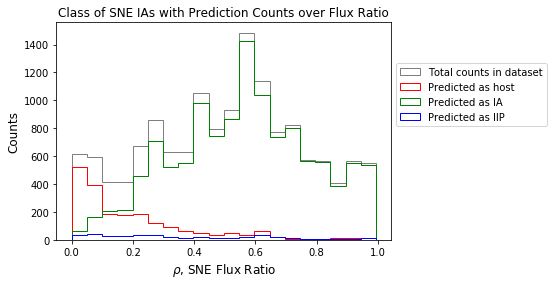

In [13]:
y_pred_class_ia_predicted_hosts = y_pred_class_ia == 0
y_pred_class_ia_predicted_ia = y_pred_class_ia == 1
y_pred_class_ia_predicted_iip = y_pred_class_ia == 2

rfr_ia_test = rfr_ia[index_begin_test_set:index_end_test_set]
(counts_rfr_ia_total, bins_rfr_ia_total, patches_rfr_ia_total) = plt.hist(rfr_ia_test, label="Total counts in dataset", bins=20, histtype='step', color='black', alpha=0.5)
(counts_rfr_ia_phost, bins_rfr_ia_phost, patches_rfr_ia_phost) = plt.hist(rfr_ia_test[y_pred_class_ia_predicted_hosts], label="Predicted as host", bins=bins_rfr_ia_total, histtype='step', color='red')
(counts_rfr_ia_pia, bins_rfr_ia_pia, patches_rfr_ia_pia) = plt.hist(rfr_ia_test[y_pred_class_ia_predicted_ia], label="Predicted as IA", bins=bins_rfr_ia_total, histtype='step', color='green')
(counts_rfr_ia_piip, bins_rfr_ia_piip, patches_rfr_ia_piip) = plt.hist(rfr_ia_test[y_pred_class_ia_predicted_iip], label="Predicted as IIP", bins=bins_rfr_ia_total, histtype='step', color='blue')
plt.xlabel(r'$\rho$, SNE Flux Ratio', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Class of SNE IAs with Prediction Counts over Flux Ratio')
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()

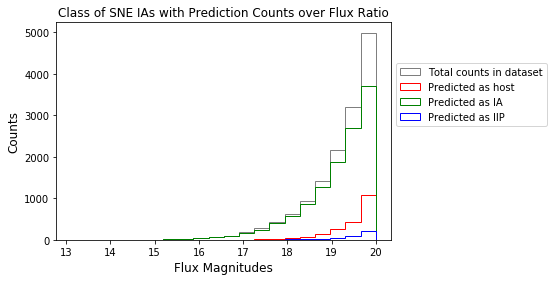

In [14]:
rmags_ia_test = rmags_ia[index_begin_test_set:index_end_test_set]
(counts_mags_ia_total, bins_mags_ia_total, patches_mags_ia_total) = plt.hist(rmags_ia_test, label="Total counts in dataset", bins=20, histtype='step', color='black', alpha=0.5)
(counts_mags_ia_phost, bins_mags_ia_phost, patches_mags_ia_phost) = plt.hist(rmags_ia_test[y_pred_class_ia_predicted_hosts], label="Predicted as host", bins=bins_mags_ia_total, histtype='step', color='red')
(counts_mags_ia_pia, bins_mags_ia_pia, patches_mags_ia_pia) = plt.hist(rmags_ia_test[y_pred_class_ia_predicted_ia], label="Predicted as IA", bins=bins_mags_ia_total, histtype='step', color='green')
(counts_mags_ia_piip, bins_mags_ia_piip, patches_mags_ia_piip) = plt.hist(rmags_ia_test[y_pred_class_ia_predicted_iip], label="Predicted as IIP", bins=bins_mags_ia_total, histtype='step', color='blue')
plt.xlabel('Flux Magnitudes', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Class of SNE IAs with Prediction Counts over Flux Ratio')
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()

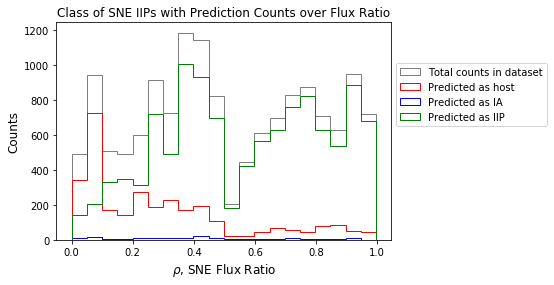

In [15]:
y_pred_class_iip_predicted_hosts = y_pred_class_iip == 0
y_pred_class_iip_predicted_ia = y_pred_class_iip == 1
y_pred_class_iip_predicted_iip = y_pred_class_iip == 2

rfr_iip_test = rfr_iip[index_begin_test_set:index_end_test_set]
(counts_rfr_iip_total, bins_rfr_iip_total, patches_rfr_iip_total) = plt.hist(rfr_iip_test, label="Total counts in dataset", bins=20, histtype='step', color='black', alpha=0.5)
(counts_rfr_iip_phost, bins_rfr_iip_phost, patches_rfr_iip_phost) = plt.hist(rfr_iip_test[y_pred_class_iip_predicted_hosts], label="Predicted as host", bins=bins_rfr_iip_total, histtype='step', color='red')
(counts_rfr_iip_pia, bins_rfr_iip_pia, patches_rfr_iip_pia) = plt.hist(rfr_iip_test[y_pred_class_iip_predicted_ia], label="Predicted as IA", bins=bins_rfr_iip_total, histtype='step', color='blue')
(counts_rfr_iip_piip, bins_rfr_iip_piip, patches_iip_piip) = plt.hist(rfr_iip_test[y_pred_class_iip_predicted_iip], label="Predicted as IIP", bins=bins_rfr_iip_total, histtype='step', color='green')
plt.xlabel(r'$\rho$, SNE Flux Ratio', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Class of SNE IIPs with Prediction Counts over Flux Ratio')
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()

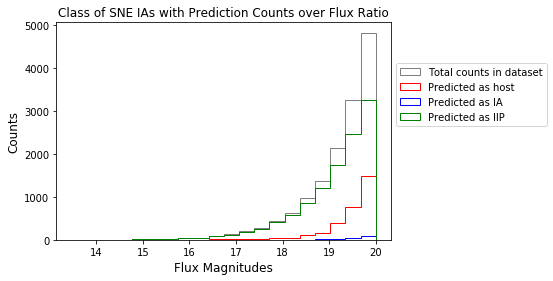

In [16]:
rmags_iip_test = rmags_iip[index_begin_test_set:index_end_test_set]
(counts_mags_iip_total, bins_mags_iip_total, patches_mags_iip_total) = plt.hist(rmags_iip_test, label="Total counts in dataset", bins=20, histtype='step', color='black', alpha=0.5)
(counts_mags_iip_phost, bins_mags_iip_phost, patches_mags_iip_phost) = plt.hist(rmags_iip_test[y_pred_class_iip_predicted_hosts], label="Predicted as host", bins=bins_mags_iip_total, histtype='step', color='red')
(counts_mags_iip_pia, bins_mags_iip_pia, patches_mags_iip_pia) = plt.hist(rmags_iip_test[y_pred_class_iip_predicted_ia], label="Predicted as IA", bins=bins_mags_iip_total, histtype='step', color='blue')
(counts_mags_iip_piip, bins_mags_iip_piip, patches_mags_iip_piip) = plt.hist(rmags_iip_test[y_pred_class_iip_predicted_iip], label="Predicted as IIP", bins=bins_mags_iip_total, histtype='step', color='green')
plt.xlabel('Flux Magnitudes', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Class of SNE IAs with Prediction Counts over Flux Ratio')
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()

In [17]:
med_rfr_ia_bins = [(bins_rfr_ia_total[i]+bins_rfr_ia_total[i+1])/2 for i in range(len(bins_rfr_ia_total)-1)]

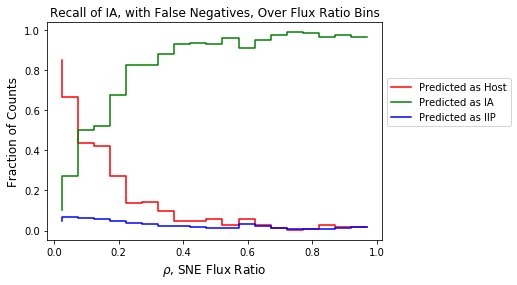

In [18]:
ia_efficiency_host_over_total = counts_rfr_ia_phost / counts_rfr_ia_total
ia_efficiency_ia_over_total = counts_rfr_ia_pia / counts_rfr_ia_total
ia_efficiency_iip_over_total = counts_rfr_ia_piip / counts_rfr_ia_total

plt.step(med_rfr_ia_bins, ia_efficiency_host_over_total, label="Predicted as Host", color="red")
plt.step(med_rfr_ia_bins, ia_efficiency_ia_over_total, label="Predicted as IA", color="green")
plt.step(med_rfr_ia_bins, ia_efficiency_iip_over_total, label="Predicted as IIP", color="blue")
plt.xlabel(r'$\rho$, SNE Flux Ratio', fontsize=12)
plt.ylabel('Fraction of Counts', fontsize=12)
plt.title("Recall of IA, with False Negatives, Over Flux Ratio Bins")
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")

plt.show()

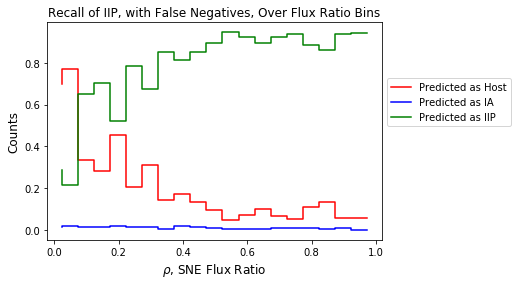

In [19]:
med_rfr_iip_bins = [(bins_rfr_iip_total[i]+bins_rfr_iip_total[i+1])/2 for i in range(len(bins_rfr_iip_total)-1)]

iip_efficiency_host_over_total = counts_rfr_iip_phost / counts_rfr_iip_total
iip_efficiency_ia_over_total = counts_rfr_iip_pia / counts_rfr_iip_total
iip_efficiency_iip_over_total = counts_rfr_iip_piip / counts_rfr_iip_total

plt.step(med_rfr_iip_bins, iip_efficiency_host_over_total, label="Predicted as Host", color="red")
plt.step(med_rfr_iip_bins, iip_efficiency_ia_over_total, label="Predicted as IA", color="blue")
plt.step(med_rfr_iip_bins, iip_efficiency_iip_over_total, label="Predicted as IIP", color="green")
plt.xlabel(r'$\rho$, SNE Flux Ratio', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title("Recall of IIP, with False Negatives, Over Flux Ratio Bins")
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()

## Looking at Precision from Predicted Classes

In [20]:
y_predicted_hosts = (y_pred_labels == 0)
y_predicted_hosts_class_hosts = y_predicted_hosts[:len_each_test_class]
y_predicted_hosts_class_ia = y_predicted_hosts[len_each_test_class:2*len_each_test_class]
y_predicted_hosts_class_iip = y_predicted_hosts[2*len_each_test_class:]

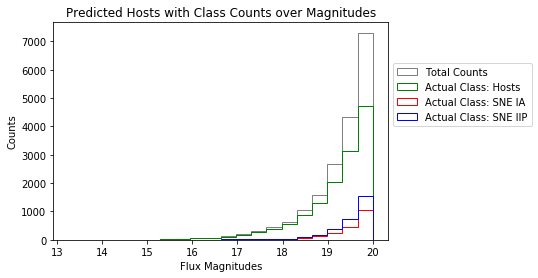

In [34]:
rmags_predicted_hosts_class_hosts = rmags_hosts[index_begin_test_set:index_end_test_set][y_predicted_hosts_class_hosts.astype(bool)]
rmags_predicted_hosts_class_ia = rmags_ia[index_begin_test_set:index_end_test_set][y_predicted_hosts_class_ia.astype(bool)]
rmags_predicted_hosts_class_iip = rmags_iip[index_begin_test_set:index_end_test_set][y_predicted_hosts_class_iip.astype(bool)]

(counts_mags_pred_hosts_total, bins_mags_pred_hosts_total, patches_mags_pred_hosts_total) = \
    plt.hist(np.concatenate([rmags_predicted_hosts_class_hosts,
                             rmags_predicted_hosts_class_ia,
                             rmags_predicted_hosts_class_iip]),
             histtype='step', color="black", alpha=0.5, bins=20, label="Total Counts")
    
(counts_mags_pred_hosts_class_hosts, bins_mags_pred_hosts_class_hosts, patches_mags_pred_hosts_class_hosts) =\
    plt.hist(rmags_predicted_hosts_class_hosts, histtype='step', color="green", 
             bins=bins_mags_pred_hosts_total, label="Actual Class: Hosts")

(counts_mags_pred_hosts_class_ia, bins_mags_pred_hosts_class_ia, patches_mags_pred_hosts_class_ia) =\
    plt.hist(rmags_predicted_hosts_class_ia, histtype='step', color="red", 
             bins=bins_mags_pred_hosts_total, label="Actual Class: SNE IA")

(counts_mags_pred_hosts_class_iip, bins_mags_pred_hosts_class_iip, patches_mags_pred_hosts_class_iip) =\
    plt.hist(rmags_predicted_hosts_class_iip, histtype='step', color="blue", 
             bins=bins_mags_pred_hosts_total, label="Actual Class: SNE IIP")

plt.title("Predicted Hosts with Class Counts over Magnitudes")
plt.ylabel("Counts")
plt.xlabel("Flux Magnitudes")
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()

/home/dgandhi/.conda/envs/desi_sbenzvi_lab/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/home/dgandhi/.conda/envs/desi_sbenzvi_lab/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/home/dgandhi/.conda/envs/desi_sbenzvi_lab/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


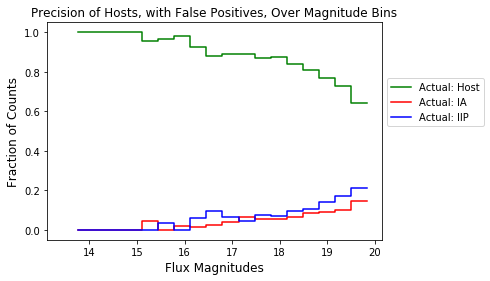

In [40]:
med_rmags_pred_host_bins = [(bins_mags_pred_hosts_total[i]+bins_mags_pred_hosts_total[i+1])/2 for i in range(len(bins_mags_pred_hosts_total)-1)]

# There's a zero in one of the bins...
pred_host_class_host_efficiency_over_total = counts_mags_pred_hosts_class_hosts / counts_mags_pred_hosts_total
pred_host_class_ia_efficiency_over_total = counts_mags_pred_hosts_class_ia / counts_mags_pred_hosts_total
pred_host_class_iip_efficiency_over_total = counts_mags_pred_hosts_class_iip / counts_mags_pred_hosts_total

plt.step(med_rmags_pred_host_bins, pred_host_class_host_efficiency_over_total, label="Actual: Host", color="green")
plt.step(med_rmags_pred_host_bins, pred_host_class_ia_efficiency_over_total, label="Actual: IA", color="red")
plt.step(med_rmags_pred_host_bins, pred_host_class_iip_efficiency_over_total, label="Actual: IIP", color="blue")
plt.xlabel('Flux Magnitudes', fontsize=12)
plt.ylabel('Fraction of Counts', fontsize=12)
plt.title("Precision of Hosts, with False Positives, Over Magnitude Bins")
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()

In [22]:
y_predicted_ia = (y_pred_labels == 1)
y_predicted_ia_class_hosts = y_predicted_ia[:len_each_test_class]
y_predicted_ia_class_ia = y_predicted_ia[len_each_test_class:2*len_each_test_class]
y_predicted_ia_class_iip = y_predicted_ia[2*len_each_test_class:]

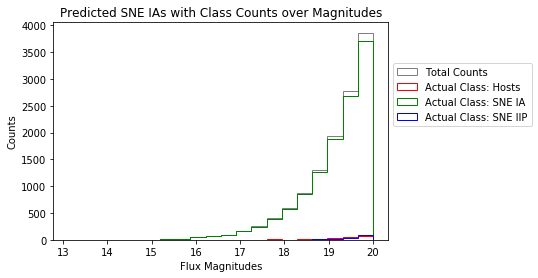

In [42]:
rmags_predicted_ia_class_hosts = rmags_hosts[index_begin_test_set:index_end_test_set][y_predicted_ia_class_hosts.astype(bool)]
rmags_predicted_ia_class_ia = rmags_ia[index_begin_test_set:index_end_test_set][y_predicted_ia_class_ia.astype(bool)]
rmags_predicted_ia_class_iip = rmags_iip[index_begin_test_set:index_end_test_set][y_predicted_ia_class_iip.astype(bool)]

(counts_mags_pred_ia_total, bins_mags_pred_ia_total, patches_mags_pred_ia_total) = \
    plt.hist(np.concatenate([rmags_predicted_ia_class_hosts,
                             rmags_predicted_ia_class_ia,
                             rmags_predicted_ia_class_iip]),
             histtype='step', color="black", bins=20, alpha=0.5, label="Total Counts")

(counts_mags_pred_ia_class_hosts, bins_mags_pred_ia_class_hosts, patches_mags_pred_ia_class_hosts) = \
    plt.hist(rmags_predicted_ia_class_hosts, histtype='step', color="red", 
             bins=bins_mags_pred_ia_total, label="Actual Class: Hosts")

(counts_mags_pred_ia_class_ia, bins_mags_pred_ia_class_ia, patches_mags_pred_ia_class_ia) = \
    plt.hist(rmags_predicted_ia_class_ia, histtype='step', color="green", 
             bins=bins_mags_pred_ia_total, label="Actual Class: SNE IA")

(counts_mags_pred_ia_class_iip, bins_mags_pred_ia_class_iip, patches_mags_pred_ia_class_iip) = \
    plt.hist(rmags_predicted_ia_class_iip, histtype='step', color="blue", 
             bins=bins_mags_pred_ia_total, label="Actual Class: SNE IIP")

plt.title("Predicted SNE IAs with Class Counts over Magnitudes")
plt.ylabel("Counts")
plt.xlabel("Flux Magnitudes")
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()


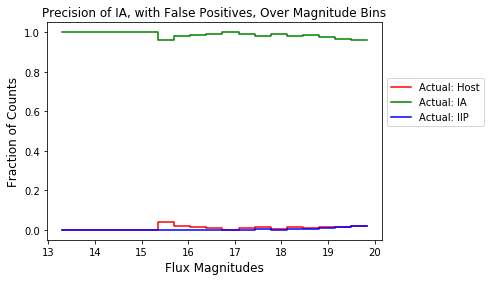

In [48]:
med_rmags_pred_ia_bins = [(bins_mags_pred_ia_total[i]+bins_mags_pred_ia_total[i+1])/2 for i in range(len(bins_mags_pred_ia_total)-1)]

pred_ia_class_host_efficiency_over_total = counts_mags_pred_ia_class_hosts / counts_mags_pred_ia_total
pred_ia_class_ia_efficiency_over_total = counts_mags_pred_ia_class_ia / counts_mags_pred_ia_total
pred_ia_class_iip_efficiency_over_total = counts_mags_pred_ia_class_iip / counts_mags_pred_ia_total

plt.step(med_rmags_pred_ia_bins, pred_ia_class_host_efficiency_over_total, label="Actual: Host", color="red")
plt.step(med_rmags_pred_ia_bins, pred_ia_class_ia_efficiency_over_total, label="Actual: IA", color="green")
plt.step(med_rmags_pred_ia_bins, pred_ia_class_iip_efficiency_over_total, label="Actual: IIP", color="blue")
plt.xlabel('Flux Magnitudes', fontsize=12)
plt.ylabel('Fraction of Counts', fontsize=12)
plt.title("Precision of Predicted IA, with False Positives, Over Magnitude Bins")
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()

In [44]:
y_predicted_iip = (y_pred_labels == 2)
y_predicted_iip_class_hosts = y_predicted_iip[:len_each_test_class]
y_predicted_iip_class_ia = y_predicted_iip[len_each_test_class:2*len_each_test_class]
y_predicted_iip_class_iip = y_predicted_iip[2*len_each_test_class:]

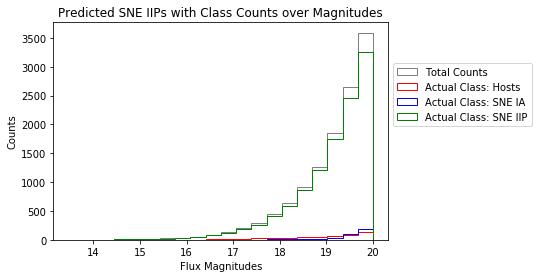

In [45]:
rmags_predicted_iip_class_hosts = rmags_hosts[index_begin_test_set:index_end_test_set][y_predicted_iip_class_hosts.astype(bool)]
rmags_predicted_iip_class_ia = rmags_ia[index_begin_test_set:index_end_test_set][y_predicted_iip_class_ia.astype(bool)]
rmags_predicted_iip_class_iip = rmags_iip[index_begin_test_set:index_end_test_set][y_predicted_iip_class_iip.astype(bool)]


(counts_mags_pred_iip_total, bins_mags_pred_iip_total, patches_mags_pred_iip_total) = \
    plt.hist(np.concatenate([rmags_predicted_iip_class_hosts,
                             rmags_predicted_iip_class_ia,
                             rmags_predicted_iip_class_iip]), 
             histtype='step', color="black", bins=20, alpha=0.5, label="Total Counts")

(counts_mags_pred_iip_class_hosts, bins_mags_pred_iip_class_hosts, patches_mags_pred_iip_class_hosts) = \
    plt.hist(rmags_predicted_iip_class_hosts, histtype='step', color="red", 
             bins=bins_mags_pred_iip_total, label="Actual Class: Hosts")

(counts_mags_pred_iip_class_ia, bins_mags_pred_iip_class_ia, patches_mags_pred_iip_class_ia) = \
    plt.hist(rmags_predicted_iip_class_ia, histtype='step', color="blue", 
             bins=bins_mags_pred_iip_total, label="Actual Class: SNE IA")

(counts_mags_pred_iip_class_iip, bins_mags_pred_iip_class_iip, patches_mags_pred_iip_class_iip) = \
    plt.hist(rmags_predicted_iip_class_iip, histtype='step', color="green", 
             bins=bins_mags_pred_iip_total, label="Actual Class: SNE IIP")

plt.title("Predicted SNE IIPs with Class Counts over Magnitudes")
plt.ylabel("Counts")
plt.xlabel("Flux Magnitudes")
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()


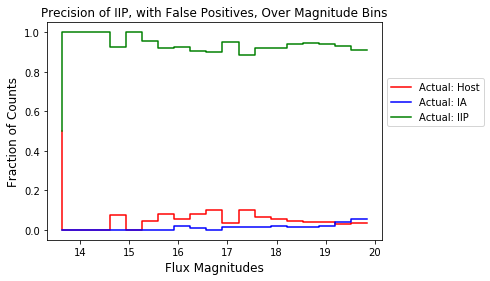

In [49]:
med_rmags_pred_iip_bins = [(bins_mags_pred_iip_total[i]+bins_mags_pred_iip_total[i+1])/2 for i in range(len(bins_mags_pred_iip_total)-1)]

pred_iip_class_host_efficiency_over_total = counts_mags_pred_iip_class_hosts / counts_mags_pred_iip_total
pred_iip_class_ia_efficiency_over_total = counts_mags_pred_iip_class_ia / counts_mags_pred_iip_total
pred_iip_class_iip_efficiency_over_total = counts_mags_pred_iip_class_iip / counts_mags_pred_iip_total

plt.step(med_rmags_pred_iip_bins, pred_iip_class_host_efficiency_over_total, label="Actual: Host", color="red")
plt.step(med_rmags_pred_iip_bins, pred_iip_class_ia_efficiency_over_total, label="Actual: IA", color="blue")
plt.step(med_rmags_pred_iip_bins, pred_iip_class_iip_efficiency_over_total, label="Actual: IIP", color="green")
plt.xlabel('Flux Magnitudes', fontsize=12)
plt.ylabel('Fraction of Counts', fontsize=12)
plt.title("Precision of Predicted IIP, with False Positives, Over Magnitude Bins")
plt.legend(bbox_to_anchor=(1,0.5), loc="lower left")
plt.show()